In [55]:
# Import required libraries
import pandas as pd

from sklearn.model_selection import train_test_split

import pylangkit.naive_bayes as nb

In [2]:
# Read input data
df = pd.read_csv('resources/lang_data.csv')

In [3]:
# Show data' statistics
# Statistics shown that there exists some empty data in text column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2839 entries, 0 to 2838
Data columns (total 2 columns):
text        2761 non-null object
language    2839 non-null object
dtypes: object(2)
memory usage: 44.4+ KB


In [4]:
# Display empty samples (78 entries)
df[df.text.isnull()]

,text,language
7,NaN,Afrikaans
11,NaN,Afrikaans
17,NaN,Afrikaans
51,NaN,Nederlands
70,NaN,English
96,NaN,English
107,NaN,Afrikaans
116,NaN,English
120,NaN,Afrikaans
187,NaN,Afrikaans


In [5]:
# Remove emtpy samples
df.dropna(inplace=True)

In [6]:
# So far we have a dataset, preperred for further processing, 
# e.g. training language classifying model
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 2838
Data columns (total 2 columns):
text        2761 non-null object
language    2761 non-null object
dtypes: object(2)
memory usage: 64.7+ KB


In [7]:
# Show language categories and text distributions over languages
df.language.value_counts()

English       2055
Afrikaans      639
Nederlands      67
Name: language, dtype: int64

In [8]:
# Show first 5 rows of dataset for Nederlands language
df[df.language == 'Nederlands'].head()

,text,language
64,"Je moet geen oude schoenen weggooien, voordat ...",Nederlands
93,"Wie zaait, zal oogsten.",Nederlands
119,"Wie het eerst komt, het eerst maalt.",Nederlands
143,Gedane zaken nemen geen keer.,Nederlands
170,Aan alles komt een eind.,Nederlands


In [ ]:
# Split of dataset to train and test (80% train, 20% test)
# And save it to the files
df_train, df_test = train_test_split(df, test_size = 0.2)

df_train.to_csv('resources/lang_data_train.csv', index=False)
df_test.to_csv('resources/lang_data_test.csv', index=False)

In [56]:
# Or, load preperred datasets from file.
df_train = pd.read_csv('resources/lang_data_train.csv')
df_test = pd.read_csv('resources/lang_data_test.csv')

In [10]:
# See if we distribute all languages properly over train and test sets
# e.g. for Nederlands language we have text data in both train and test sets
print('Train\n{}\n\nTest\n{}'.format(df_train.language.value_counts(), df_test.language.value_counts()))

Train
English       1656
Afrikaans      498
Nederlands      54
Name: language, dtype: int64

Test
English       399
Afrikaans     141
Nederlands     13
Name: language, dtype: int64


In [11]:
# Create a model
model = nb.NaiveBayes()

In [12]:
# Train model
# and save trained model on disk
# model.fit(df_train.as_matrix())
# model.dump_model('trained_model.pickle')

# Or load trainded model from file
model.load_model('resources/trained_model.pickle')

In [13]:
# Make prediction and print out misclassified text samples
predicted = model.classify(df_test.text.as_matrix())

df = pd.DataFrame(list(map(lambda x: (x[0][0], x[0][1], x[1],), zip(predicted, df_test.language))), 
                 columns=['text', 'predicted', 'actual'])
df.loc[df.predicted != df.actual]

,text,predicted,actual
30,Schijn bedriegt.,Afrikaans,Nederlands
45,Het is niet al goud wat blinkt.,Afrikaans,Nederlands
186,Misdaad loont niet.,Afrikaans,Nederlands
259,Soort zoekt soort.,Afrikaans,Nederlands
311,Oude liefde roest niet.,Afrikaans,Nederlands
371,"Wie het eerst komt, het eerst maalt.",Afrikaans,Nederlands
407,Geen woorden maar daden.,Afrikaans,Nederlands
517,Een gewaarschuwd mens telt voor twee.,Afrikaans,Nederlands


Evaluation
==========

In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix


y_true = df_test.language
y_predicted = list(map(lambda x: x[1], predicted))
confusion_matrix(y_true, y_predicted, labels=['English', 'Afrikaans', 'Nederlands'])

array([[399,   0,   0],
       [  0, 141,   0],
       [  0,   8,   5]])

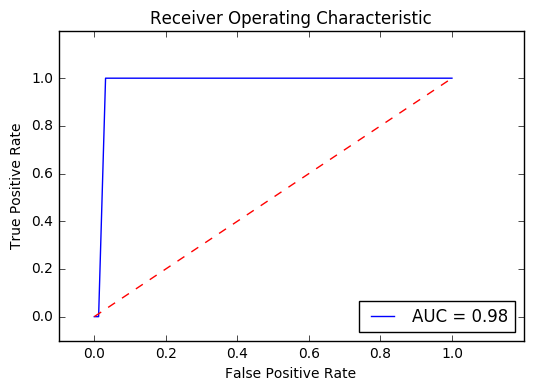

In [16]:
# Precision, Recall, ROC
import numpy as np
from sklearn.metrics import roc_curve, auc


mapped_values = dict(English=0, Afrikaans=1, Nederlands=2)
y_true = np.array(df_test.language.map(mapped_values).values, dtype=float)
y_predicted = np.array([mapped_values[x[1]] for x in predicted], dtype=float)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predicted, pos_label=True)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted, target_names=list(mapped_values.keys())))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       399
        1.0       0.95      1.00      0.97       141
        2.0       1.00      0.38      0.56        13

avg / total       0.99      0.99      0.98       553



In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

driver = webdriver.Safari(quiet=True)
driver.get("http://www.python.org")
assert "Python" in driver.title
elem = driver.find_element_by_name("q")
elem.clear()
elem.send_keys("pycon")
elem.send_keys(Keys.RETURN)
assert "No results found." not in driver.page_source
driver.close()

In [5]:
help(webdriver.safari.webdriver)

Help on module selenium.webdriver.safari.webdriver in selenium.webdriver.safari:

NAME
    selenium.webdriver.safari.webdriver

DESCRIPTION
    # Licensed to the Software Freedom Conservancy (SFC) under one
    # or more contributor license agreements.  See the NOTICE file
    # distributed with this work for additional information
    # regarding copyright ownership.  The SFC licenses this file
    # to you under the Apache License, Version 2.0 (the
    # "License"); you may not use this file except in compliance
    # with the License.  You may obtain a copy of the License at
    #
    #   http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing,
    # software distributed under the License is distributed on an
    # "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
    # KIND, either express or implied.  See the License for the
    # specific language governing permissions and limitations
    # under the License.

CLASSES


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [4]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
X         

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [5]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer


transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X.toarray())
tfidf.toarray()  

array([[ 0.        ,  0.43306685,  0.56943086,  0.43306685,  0.        ,
         0.        ,  0.33631504,  0.        ,  0.43306685],
       [ 0.        ,  0.24014568,  0.        ,  0.24014568,  0.        ,
         0.89006176,  0.18649454,  0.        ,  0.24014568],
       [ 0.56115953,  0.        ,  0.        ,  0.        ,  0.56115953,
         0.        ,  0.23515939,  0.56115953,  0.        ],
       [ 0.        ,  0.43306685,  0.56943086,  0.43306685,  0.        ,
         0.        ,  0.33631504,  0.        ,  0.43306685]])

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

per_vectorizer = TfidfVectorizer(decode_error='ignore',
                                 min_df=1)

personality_tfidf = per_vectorizer.fit_transform(corpus)
personality_tfidf.toarray()

array([[ 0.        ,  0.43877674,  0.54197657,  0.43877674,  0.        ,
         0.        ,  0.35872874,  0.        ,  0.43877674],
       [ 0.        ,  0.27230147,  0.        ,  0.27230147,  0.        ,
         0.85322574,  0.22262429,  0.        ,  0.27230147],
       [ 0.55280532,  0.        ,  0.        ,  0.        ,  0.55280532,
         0.        ,  0.28847675,  0.55280532,  0.        ],
       [ 0.        ,  0.43877674,  0.54197657,  0.43877674,  0.        ,
         0.        ,  0.35872874,  0.        ,  0.43877674]])

In [22]:
from sklearn.datasets import fetch_20newsgroups


remove = ()
categories = None
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)

In [67]:
mapped = dict(English=0, Afrikaans=1, Nederlands=2)
df_train['target'] = df_train.language.map(mapped)
df_test['target'] = df_train.language.map(mapped)

In [94]:
from sklearn.feature_extraction.text import HashingVectorizer


vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
# vectorizer = HashingVectorizer()

X_train = vectorizer.fit_transform(df_train.text.as_matrix())
X_test = vectorizer.transform(df_test.text.as_matrix())

y_train, y_test = df_train.target, df_test.target

In [100]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics


# clf = RidgeClassifier(tol=1e-2, solver="lsqr")
# clf = Perceptron(n_iter=50)
# clf = PassiveAggressiveClassifier(n_iter=50)
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = RandomForestClassifier(n_estimators=100)
# clf = MultinomialNB(alpha=.01)
# clf = LinearSVC(loss='l2', penalty='l2', dual=False, tol=1e-3)
# clf = SGDClassifier(alpha=.0001, n_iter=50, penalty='elasticnet')
clf = NearestCentroid()

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(metrics.classification_report(y_test, pred,
                                            target_names=list(mapped.keys())))
print(metrics.confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

    English       0.76      0.75      0.76       418
 Nederlands       0.21      0.23      0.22       123
  Afrikaans       0.00      0.00      0.00        12

avg / total       0.62      0.62      0.62       553

[[313  98   7]
 [ 91  28   4]
 [  7   5   0]]


In [108]:
X_test[0].data, df_test.text.loc[0]

(array([ 0.56702109,  0.3295814 ,  0.46679625,  0.59326592]),
 'A fish out of water')

In [119]:
dd = pd.read_csv('/Users/alex/Documents/Tests_For_Job/LevelUP/notebook_work_dir/Spam_Filter/data.csv', 
                 header=None,
                 names=['data', 'target'])

dd_train, dd_test = train_test_split(dd, test_size = 0.2)

In [121]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)

X_train = vectorizer.fit_transform(dd_train.data.as_matrix())
X_test = vectorizer.transform(dd_test.data.as_matrix())

y_train, y_test = dd_train.target, dd_test.target

In [123]:
# clf = RidgeClassifier(tol=1e-2, solver="lsqr")
# clf = Perceptron(n_iter=50)
# clf = PassiveAggressiveClassifier(n_iter=50)
# clf = KNeighborsClassifier(n_neighbors=3)
# clf = RandomForestClassifier(n_estimators=100)
clf = MultinomialNB(alpha=.01)
# clf = LinearSVC(loss='l2', penalty='l2', dual=False, tol=1e-3)
# clf = SGDClassifier(alpha=.0001, n_iter=50, penalty='elasticnet')
# clf = NearestCentroid()

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(metrics.classification_report(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93        80
          1       0.94      0.99      0.96       144

avg / total       0.95      0.95      0.95       224

[[ 71   9]
 [  2 142]]


In [165]:
a = pd.read_excel('/Users/alex/Downloads/SampleDataML.xlsx',
                  parse_cols=range(2, 6))

In [166]:
a.Category.value_counts()

Home | Hobby & UnderhÃ¥llning | Radiostyrt | DrÃ¶nare                      15
Home | Hobby & UnderhÃ¥llning | Hoverboards                                 6
Home | Hemmet | Bygg | El & Elinstallation | Batterier                      5
Home | Fritid & TrÃ¤ning | TrÃ¤ning & Tillskott | Aktivitetsarmband         3
Home | Hemmet | Bygg | El & Elinstallation | Belysning | LED-Lampor E27     2
Name: Category, dtype: int64

In [167]:
mapped_values = dict()

for index, value in enumerate(a.Category.unique()):
    mapped_values[value] = index
    
a['target'] = a.Category.map(mapped_values)


In [168]:
a['data'] = a[['Product title', 'description', 'description-short']].apply(lambda x: ' '.join(x), axis=1)

In [177]:
a_train, a_test = train_test_split(a, test_size = 0.2)

vectorizer = TfidfVectorizer(sublinear_tf=True, 
                             max_df=0.5,
                             stop_words='english')

X_train = vectorizer.fit_transform(a_train.data.as_matrix())
X_test = vectorizer.transform(a_test.data.as_matrix())

y_train, y_test = a_train.target, a_test.target

clf = MultinomialNB(alpha=.01)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(metrics.classification_report(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         2
          2       1.00      1.00      1.00         1
          3       1.00      1.00      1.00         3
          4       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         7

[[2 0 0 0]
 [0 1 0 0]
 [0 0 3 0]
 [0 0 0 1]]


In [193]:
# b = a_test.copy()
# b['predicted'] = pred
# b
a_test.copy()

,Product title,Category,description,description-short,target,data,predicted,a
6,Belkin Wemo Led Starterkit 2X E27 Bulbs + Wemo...,Home | Hemmet | Bygg | El & Elinstallation | B...,"<font size=""2"">â€‹</font>Med WeMo-startpaketet...",BELKIN WEMO LED STARTERKIT 2x E27 BULBS + WEMO...,2,Belkin Wemo Led Starterkit 2X E27 Bulbs + Wemo...,2,2
3,Dl 2032-B2 Cr2032,Home | Hemmet | Bygg | El & Elinstallation | B...,"2032 LITIUM ELEKTRONIKBATTERIIEC: CR20323,0 Vo...",DL 2032-B2 CR2032,1,Dl 2032-B2 Cr2032 2032 LITIUM ELEKTRONIKBATTER...,1,1
4,Ultra Power Mn 1400 K2 Lr14,Home | Hemmet | Bygg | El & Elinstallation | B...,<p>BÃ¤st fÃ¶r apparater som drar mycket strÃ¶m...,"<p>Ultra Power MN 1400 K2 LR14</p>\n<div id=""m...",1,Ultra Power Mn 1400 K2 Lr14 <p>BÃ¤st fÃ¶r app...,1,1
24,"Denver Hoverboard 10"" Vit",Home | Hobby & UnderhÃ¥llning | Hoverboards,"<p><strong>Motoriserad balans-brÃ¤da, Ã¤ven ka...","Denver HoverBoard 10"" Vit",4,"Denver Hoverboard 10"" Vit <p><strong>Motoriser...",4,4
19,Parrot Bebop Drone 2 RÃ¶d/Svart,Home | Hobby & UnderhÃ¥llning | Radiostyrt | D...,<p>Ett tillbehÃ¶r med perfekt passform och til...,Parrot Bebop Drone 2 RÃ¶d/Svart,3,Parrot Bebop Drone 2 RÃ¶d/Svart <p>Ett tillbeh...,3,3
29,Denver DrÃ¶nare med Hd-Kamera,Home | Hobby & UnderhÃ¥llning | Radiostyrt | D...,"<p>- 4GHz, 4 kanals - 6 axel drone med HD-kame...",Denver DrÃ¶nare med HD-kamera,3,"Denver DrÃ¶nare med Hd-Kamera <p>- 4GHz, 4 kan...",3,3
12,Parrot Ar. Drone 2.0 Elite Ed. Snow,Home | Hobby & UnderhÃ¥llning | Radiostyrt | D...,<p><strong>Radiostyrd helikopter med inbyggda ...,Parrot AR. DRONE 2.0 Elite Ed. Snow,3,Parrot Ar. Drone 2.0 Elite Ed. Snow <p><strong...,3,3
